# Customer Segmentation

 The objective of this use case is to classify customers based on their characteristics so that the company can use appropriate marketing stratergies against each class.

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
from sklearn.decomposition import PCA

In [105]:
train = pd.read_csv(r'C:\Users\test\Downloads\Customer Segmentation\Train_aBjfeNk.csv')
test = pd.read_csv(r'C:\Users\test\Downloads\Customer Segmentation\Test_LqhgPWU.csv')

In [106]:
# Numerical : Age, Work Experience, Family size 
# Dichotomus : Gender, Ever married, Graduate
# Polychotomus : Profession, Spending Score
# Target : Segmentation (4)

columns = train.columns.tolist()
numerical = [feature for feature in columns if train[feature].dtypes != 'O']
categorical = [feature for feature in columns if feature not in numerical+['Segmentation']]

### Percent of missing values 

In [107]:
# Missing values % in train and test
def missing(train, test, columns):
    missing = []
    for feature in columns:
        m_train = np.round(train[feature].isna().sum()/len(train),3)*100
        m_test = np.round(test[feature].isna().sum()/len(test),3)*100
        missing.append([feature, m_train, m_test])
    miss_df = pd.DataFrame(missing, columns=['Feature', 'Train %', 'test %'])
    miss_df = miss_df[miss_df['Train %'] != 0]
    return miss_df

In [108]:
missing(train, test, numerical+categorical)

,Feature,Train %,test %
2,Work_Experience,10.3,10.2
3,Family_Size,4.2,4.3
5,Ever_Married,1.7,1.9
6,Graduated,1.0,0.9
7,Profession,1.5,1.4
9,Var_1,0.9,1.2


### Impute Missing Values

In [109]:
def impute(df):
    
    ## Ever married and Work experience 0 if age <= 22
    df['Ever_Married'] = np.where(df['Ever_Married'].isna(),
                                 np.where(df['Age'] <= 22,'No',df['Ever_Married']), df['Ever_Married'])
    
    df['Work_Experience'] = np.where(df['Work_Experience'].isna(),
                                 np.where(df['Age'] <= 22,0,df['Work_Experience']), df['Work_Experience'])
    
    df['Graduated'].fillna('No',inplace=True)# Graduated Nan with 'No'
    
    df['Ever_Married'].fillna('No',inplace=True)#  Nan with 'No'
    
    # Profession, Work Experience, Family size, var_1 : Mode
    df['Profession'].fillna(df['Profession'].mode()[0],inplace=True)
    
    df['Work_Experience'].fillna(df['Work_Experience'].mode()[0],inplace=True)
    
    df['Family_Size'].fillna(df['Family_Size'].mode()[0],inplace=True)
    
    df['Var_1'].fillna(df['Var_1'].mode()[0],inplace=True)
    

In [110]:
impute(train)
impute(test)

### Unique values in each feature

In [111]:
counts = []
for feature in numerical+categorical:
    train_test_count = [feature, train[feature].nunique(), test[feature].nunique()]
    counts.append(train_test_count)
counts_df = pd.DataFrame(counts, columns=['Column','Train','Test'])
counts_df

,Column,Train,Test
0,ID,8068,2627
1,Age,67,67
2,Work_Experience,15,15
3,Family_Size,9,9
4,Gender,2,2
5,Ever_Married,2,2
6,Graduated,2,2
7,Profession,9,9
8,Spending_Score,3,3
9,Var_1,7,7


### Graduated and non Graduated customers in each Segment 

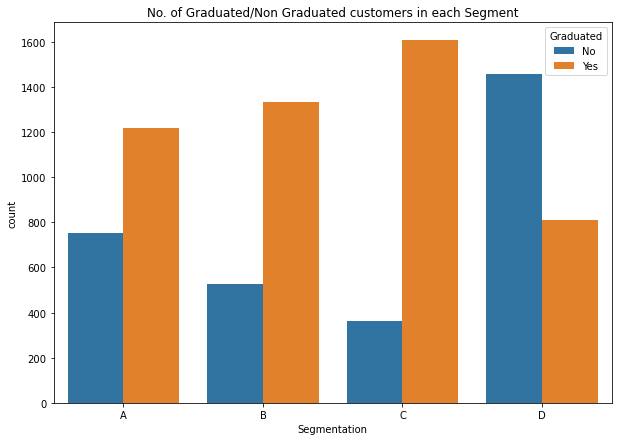

In [112]:
plt.figure(figsize=(10,7))
sns.countplot(train['Segmentation'], hue=train['Graduated'], order=['A','B','C','D'])
plt.title("No. of Graduated/Non Graduated customers in each Segment")
plt.show()

### Ever Married Customers in each Segment 

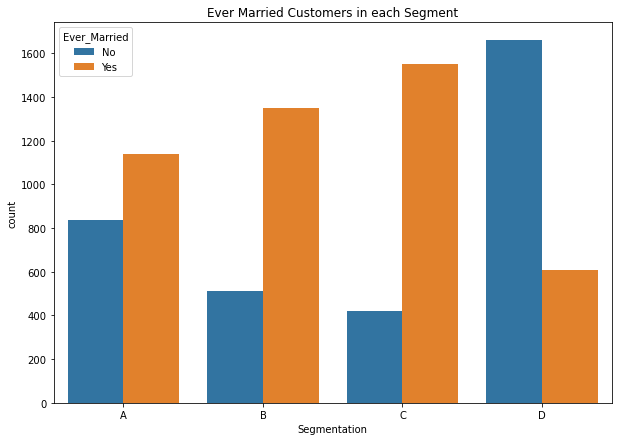

In [113]:
plt.figure(figsize=(10,7))
sns.countplot(train['Segmentation'], hue=train['Ever_Married'], order=['A','B','C','D'])
plt.title("Ever Married Customers in each Segment")
plt.show()

### Description of numerical Features 

In [18]:
def describe_num(df,numerical):
    vals = []
    for feature in numerical:
        feat_des = [feature, df[feature].nunique(),np.round(df[feature].mean(),2), min(df[feature]),
                    np.quantile(df[feature],0.25),np.quantile(df[feature],0.5),np.quantile(df[feature],0.75),
                    max(df[feature])]
        vals.append(feat_des)
    desc_num = pd.DataFrame(vals, columns=['Feature','No. Unique','Mean','Min','Q1','Q2','Q3','Max'])
    return desc_num

In [19]:
describe_num(train,numerical)

,Feature,No. Unique,Mean,Min,Q1,Q2,Q3,Max
0,ID,8068,463479.21,458982.0,461240.75,463472.5,465744.25,467974.0
1,Age,67,43.47,18.0,30.00,40.0,53.00,89.0
2,Work_Experience,15,2.37,0.0,0.00,1.0,4.00,14.0
3,Family_Size,9,2.81,1.0,2.00,2.0,4.00,9.0


In [20]:
describe_num(test,numerical)

,Feature,No. Unique,Mean,Min,Q1,Q2,Q3,Max
0,ID,2627,463433.92,458989.0,461162.5,463379.0,465696.0,467968.0
1,Age,67,43.65,18.0,30.0,41.0,53.0,89.0
2,Work_Experience,15,2.29,0.0,0.0,1.0,3.0,14.0
3,Family_Size,9,2.79,1.0,2.0,2.0,4.0,9.0


### Proportion of polychotomus variables in train and test 

In [21]:
def train_test_ratio(train, test, feature):
    train_1 = train[feature].value_counts(normalize=True).sort_values(ascending=False)
    test_1 = test[feature].value_counts(normalize=True).sort_values(ascending=False)
    
    data_values = np.array([train_1.keys(), train_1.values, test_1.values, np.round(train_1.values/test_1.values, 2)]).T
    col_names = [feature, 'Train', 'Test', 'Ratio']
    
    value_counts_df = pd.DataFrame(data_values, columns=col_names)
    return value_counts_df

In [22]:
# Profession
train_test_ratio(train, test, 'Profession')

,Profession,Train,Test,Ratio
0,Artist,0.327219,0.319756,1.02
1,Healthcare,0.165097,0.159117,1.04
2,Entertainment,0.117625,0.114579,1.03
3,Engineer,0.0866386,0.0921203,0.94
4,Doctor,0.0852752,0.0898363,0.95
5,Lawyer,0.0772186,0.0841264,0.92
6,Executive,0.0742439,0.0669966,1.11
7,Marketing,0.0361924,0.0422535,0.86
8,Homemaker,0.0304908,0.0312143,0.98


In [23]:
# Spending Score
train_test_ratio(train, test, 'Spending_Score')

,Spending_Score,Train,Test,Ratio
0,Low,0.604611,0.61515,0.98
1,Average,0.24467,0.237914,1.03
2,High,0.150719,0.146936,1.03


### Encoding categorical variables 

In [24]:
def encoding(df):
    yes_no = {'Yes':1,'No':0}
    male_female = {'Male':1,'Female':0}
    spec = {'Low':1,'Average':2,'High':3}
    prof = {'Artist':9, 'Healthcare':8, 'Entertainment':7, 'Engineer':6, 'Doctor':5, 'Lawyer':4,
           'Executive':3, 'Marketing':2, 'Homemaker':1}
    #segm = {'A':1,'B':2,'C':3,'D':4}
    
    df['Gender'] = df['Gender'].map(male_female)
    df['Ever_Married'] = df['Ever_Married'].map(yes_no)
    df['Graduated'] = df['Graduated'].map(yes_no)
    df['Profession'] = df['Profession'].map(prof)
    df['Spending_Score'] = df['Spending_Score'].map(spec)
    #df['Segmentation'] = df['Segmentation'].map(segm)
    
    # Var 1
    var = []
    for i in df['Var_1']:
        val = str(i).split('_')[1]
        var.append(int(val))
    df['Var_1'] = var
    
    df['Work_Experience'] = df['Work_Experience'].astype(int)
    df['Family_Size'] = df['Family_Size'].astype(int)

In [25]:
encoding(train)
encoding(test)

## Encoding train target
train['Segmentation'] = train['Segmentation'].map({'A':1,'B':2,'C':3,'D':4})

### Feature Creation PCA, Binning Age, Ever 

In [28]:
## Principal Component Analysis

values = ['Age', 'Work_Experience', 'Family_Size']
pca = PCA(n_components=1)

pca.fit(train[values])
l1 = pca.transform(train[values])
train['PCA'] = l1

In [29]:
## PCA on test data

l2 = pca.transform(test[values])
test['PCA'] = l2

In [30]:
def feat_creat(df):
    ## Age Binn
    age_bin = []
    for val in df['Age']:
        if (val <= 30):
            age_bin.append(1)
        elif (val>30 and val<=40):
            age_bin.append(2)
        elif (val>40 and val<=53):
            age_bin.append(3)
        else:
            age_bin.append(4)
    df['Age_Bin'] = age_bin
    
    ## Ever Married = No, Spending = LOW
    df['Ever'] = np.where(df['Ever_Married']==0, np.where(df['Spending_Score']==1, 1, 0),0)

In [31]:
feat_creat(train)
feat_creat(test)

In [32]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,PCA,Age_Bin,Ever
0,462809,1,0,22,0,8,1,1,4,4,4,-21.426367,1,1
1,462643,0,1,38,1,6,0,2,3,4,1,-5.381036,2,0
2,466315,0,1,67,1,6,1,1,1,6,2,23.604593,4,0
3,461735,1,1,67,1,4,0,3,2,6,2,23.616010,4,0
4,462669,0,1,40,1,7,0,3,6,6,1,-3.456559,2,0


### Train Test Split 

In [33]:
x = train.drop(['ID','Segmentation'],axis=1)
y = train['Segmentation']
test.drop('ID',axis=1,inplace=True)

In [38]:
## 80 - 20 Split

from sklearn.model_selection import train_test_split, cross_val_score
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

### Random Forest Classifier 

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion='gini', n_estimators= 200)

In [42]:
rfc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200)

In [43]:
rfc.score(x_test, y_test)

0.4770755885997522

In [44]:
# 5 Fold Cross Validation
cv = cross_val_score(rfc, x, y, cv=5)

In [46]:
print("Test Accuracy : ",rfc.score(x_test, y_test))
print("Average cross validation : ", np.mean(cv))

Test Accuracy :  0.4770755885997522
Average cross validation :  0.4856220869622668


In [86]:
rfc_featimp = pd.DataFrame(rfc.feature_importances_, index=x_train.columns).sort_values(by=0,ascending=False)

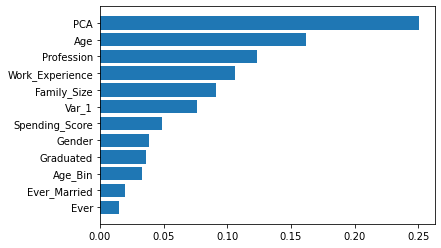

In [100]:
sort = rfc.feature_importances_.argsort()
plt.barh(x_train.columns[sort], rfc.feature_importances_[sort])
plt.show()

In [123]:
rfc_featimp

,0
PCA,0.250361
Age,0.161544
Profession,0.123125
Work_Experience,0.106410
Family_Size,0.090857
Var_1,0.075816
Spending_Score,0.049017
Gender,0.038773
Graduated,0.036209
Age_Bin,0.033284


### LGBM Classifier 

In [114]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(boosting_type='gbdt', learning_rate= 0.05, n_estimators= 100)

In [115]:
lgb.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.05)

In [116]:
lgb.score(x_test, y_test)

0.5179677819083024

In [117]:
# 5 Fold Cross Validation
cv_lgb = cross_val_score(lgb, x, y, cv=5)

In [120]:
print("LGB Test Accuracy : ",lgb.score(x_test, y_test))
print("LGB Average cross validation : ", np.mean(cv_lgb))

LGB Test Accuracy :  0.5179677819083024
LGB Average cross validation :  0.5287566711300915


In [121]:
lgb_featimp = pd.DataFrame(lgb.feature_importances_, index=x_train.columns).sort_values(by=0,ascending=False)

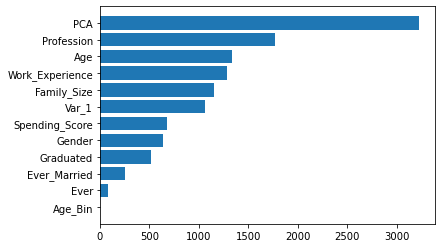

In [122]:
sort_lgb = lgb.feature_importances_.argsort()
plt.barh(x_train.columns[sort_lgb], lgb.feature_importances_[sort_lgb])
plt.show()

In [124]:
lgb_featimp

,0
PCA,3224
Profession,1765
Age,1337
Work_Experience,1283
Family_Size,1149
Var_1,1066
Spending_Score,683
Gender,640
Graduated,519
Ever_Married,251


### Cat Boost Classifier 

In [125]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()

In [126]:
cat.fit(x_train, y_train)

Learning rate set to 0.087021
0:	learn: 1.3421798	total: 106ms	remaining: 1m 45s
1:	learn: 1.3038375	total: 131ms	remaining: 1m 5s
2:	learn: 1.2745623	total: 156ms	remaining: 51.8s
3:	learn: 1.2491661	total: 178ms	remaining: 44.4s
4:	learn: 1.2293147	total: 202ms	remaining: 40.2s
5:	learn: 1.2131752	total: 213ms	remaining: 35.3s
6:	learn: 1.1976351	total: 223ms	remaining: 31.7s
7:	learn: 1.1824904	total: 231ms	remaining: 28.6s
8:	learn: 1.1702841	total: 238ms	remaining: 26.2s
9:	learn: 1.1591801	total: 245ms	remaining: 24.3s
10:	learn: 1.1485142	total: 252ms	remaining: 22.7s
11:	learn: 1.1382684	total: 262ms	remaining: 21.6s
12:	learn: 1.1304230	total: 269ms	remaining: 20.4s
13:	learn: 1.1219817	total: 276ms	remaining: 19.5s
14:	learn: 1.1158368	total: 283ms	remaining: 18.6s
15:	learn: 1.1097138	total: 290ms	remaining: 17.9s
16:	learn: 1.1039818	total: 297ms	remaining: 17.2s
17:	learn: 1.0988494	total: 305ms	remaining: 16.6s
18:	learn: 1.0942715	total: 311ms	remaining: 16.1s
19:	learn:

164:	learn: 0.9343854	total: 1.39s	remaining: 7.03s
165:	learn: 0.9337089	total: 1.4s	remaining: 7.01s
166:	learn: 0.9328811	total: 1.4s	remaining: 7s
167:	learn: 0.9323442	total: 1.41s	remaining: 7s
168:	learn: 0.9319153	total: 1.42s	remaining: 6.99s
169:	learn: 0.9309052	total: 1.43s	remaining: 6.99s
170:	learn: 0.9302575	total: 1.44s	remaining: 6.97s
171:	learn: 0.9296575	total: 1.45s	remaining: 6.96s
172:	learn: 0.9291050	total: 1.45s	remaining: 6.95s
173:	learn: 0.9284489	total: 1.46s	remaining: 6.94s
174:	learn: 0.9277388	total: 1.47s	remaining: 6.93s
175:	learn: 0.9270062	total: 1.48s	remaining: 6.92s
176:	learn: 0.9265856	total: 1.48s	remaining: 6.9s
177:	learn: 0.9261869	total: 1.49s	remaining: 6.89s
178:	learn: 0.9255918	total: 1.5s	remaining: 6.87s
179:	learn: 0.9251938	total: 1.5s	remaining: 6.86s
180:	learn: 0.9247625	total: 1.51s	remaining: 6.84s
181:	learn: 0.9240430	total: 1.52s	remaining: 6.83s
182:	learn: 0.9234872	total: 1.53s	remaining: 6.82s
183:	learn: 0.9229485	t

329:	learn: 0.8595972	total: 2.62s	remaining: 5.32s
330:	learn: 0.8591486	total: 2.63s	remaining: 5.31s
331:	learn: 0.8589788	total: 2.63s	remaining: 5.3s
332:	learn: 0.8583859	total: 2.64s	remaining: 5.29s
333:	learn: 0.8580231	total: 2.65s	remaining: 5.28s
334:	learn: 0.8575676	total: 2.66s	remaining: 5.28s
335:	learn: 0.8573108	total: 2.66s	remaining: 5.26s
336:	learn: 0.8569929	total: 2.67s	remaining: 5.25s
337:	learn: 0.8566975	total: 2.68s	remaining: 5.25s
338:	learn: 0.8562549	total: 2.69s	remaining: 5.24s
339:	learn: 0.8559738	total: 2.69s	remaining: 5.23s
340:	learn: 0.8557153	total: 2.7s	remaining: 5.22s
341:	learn: 0.8552388	total: 2.71s	remaining: 5.22s
342:	learn: 0.8549697	total: 2.72s	remaining: 5.21s
343:	learn: 0.8545692	total: 2.73s	remaining: 5.2s
344:	learn: 0.8543322	total: 2.73s	remaining: 5.19s
345:	learn: 0.8539596	total: 2.74s	remaining: 5.18s
346:	learn: 0.8535985	total: 2.75s	remaining: 5.17s
347:	learn: 0.8528834	total: 2.76s	remaining: 5.17s
348:	learn: 0.8

499:	learn: 0.8006946	total: 3.86s	remaining: 3.86s
500:	learn: 0.8003042	total: 3.87s	remaining: 3.85s
501:	learn: 0.8000802	total: 3.88s	remaining: 3.85s
502:	learn: 0.7998989	total: 3.88s	remaining: 3.84s
503:	learn: 0.7996792	total: 3.89s	remaining: 3.83s
504:	learn: 0.7993088	total: 3.9s	remaining: 3.82s
505:	learn: 0.7989458	total: 3.9s	remaining: 3.81s
506:	learn: 0.7986493	total: 3.91s	remaining: 3.8s
507:	learn: 0.7984063	total: 3.92s	remaining: 3.79s
508:	learn: 0.7981755	total: 3.92s	remaining: 3.79s
509:	learn: 0.7977941	total: 3.93s	remaining: 3.78s
510:	learn: 0.7975900	total: 3.94s	remaining: 3.77s
511:	learn: 0.7973323	total: 3.94s	remaining: 3.76s
512:	learn: 0.7970741	total: 3.95s	remaining: 3.75s
513:	learn: 0.7969315	total: 3.96s	remaining: 3.74s
514:	learn: 0.7965671	total: 3.97s	remaining: 3.73s
515:	learn: 0.7963100	total: 3.97s	remaining: 3.73s
516:	learn: 0.7959317	total: 3.98s	remaining: 3.72s
517:	learn: 0.7957415	total: 3.99s	remaining: 3.71s
518:	learn: 0.7

666:	learn: 0.7549762	total: 5.11s	remaining: 2.55s
667:	learn: 0.7547987	total: 5.12s	remaining: 2.54s
668:	learn: 0.7545415	total: 5.13s	remaining: 2.54s
669:	learn: 0.7543871	total: 5.13s	remaining: 2.53s
670:	learn: 0.7541323	total: 5.14s	remaining: 2.52s
671:	learn: 0.7540117	total: 5.15s	remaining: 2.51s
672:	learn: 0.7537533	total: 5.15s	remaining: 2.5s
673:	learn: 0.7535061	total: 5.16s	remaining: 2.5s
674:	learn: 0.7532319	total: 5.17s	remaining: 2.49s
675:	learn: 0.7528090	total: 5.18s	remaining: 2.48s
676:	learn: 0.7525535	total: 5.18s	remaining: 2.47s
677:	learn: 0.7523949	total: 5.19s	remaining: 2.46s
678:	learn: 0.7520201	total: 5.2s	remaining: 2.46s
679:	learn: 0.7519208	total: 5.21s	remaining: 2.45s
680:	learn: 0.7517326	total: 5.21s	remaining: 2.44s
681:	learn: 0.7514943	total: 5.22s	remaining: 2.43s
682:	learn: 0.7510559	total: 5.22s	remaining: 2.42s
683:	learn: 0.7508037	total: 5.23s	remaining: 2.42s
684:	learn: 0.7506433	total: 5.24s	remaining: 2.41s
685:	learn: 0.7

836:	learn: 0.7149046	total: 6.35s	remaining: 1.24s
837:	learn: 0.7146048	total: 6.36s	remaining: 1.23s
838:	learn: 0.7144402	total: 6.37s	remaining: 1.22s
839:	learn: 0.7142176	total: 6.38s	remaining: 1.21s
840:	learn: 0.7140004	total: 6.38s	remaining: 1.21s
841:	learn: 0.7137760	total: 6.39s	remaining: 1.2s
842:	learn: 0.7135663	total: 6.4s	remaining: 1.19s
843:	learn: 0.7132278	total: 6.41s	remaining: 1.18s
844:	learn: 0.7130208	total: 6.41s	remaining: 1.18s
845:	learn: 0.7127464	total: 6.42s	remaining: 1.17s
846:	learn: 0.7125270	total: 6.43s	remaining: 1.16s
847:	learn: 0.7122266	total: 6.44s	remaining: 1.15s
848:	learn: 0.7119998	total: 6.45s	remaining: 1.15s
849:	learn: 0.7116677	total: 6.45s	remaining: 1.14s
850:	learn: 0.7114116	total: 6.46s	remaining: 1.13s
851:	learn: 0.7113211	total: 6.47s	remaining: 1.12s
852:	learn: 0.7111244	total: 6.48s	remaining: 1.12s
853:	learn: 0.7108545	total: 6.48s	remaining: 1.11s
854:	learn: 0.7106452	total: 6.49s	remaining: 1.1s
855:	learn: 0.7

In [127]:
cat.score(x_test, y_test)

0.506815365551425

In [128]:
# 5 Fold Cross Validation
cv_cat = cross_val_score(cat, x, y, cv=5)

Learning rate set to 0.087021
0:	learn: 1.3429636	total: 8.64ms	remaining: 8.64s
1:	learn: 1.3055606	total: 15.6ms	remaining: 7.79s
2:	learn: 1.2764352	total: 22.9ms	remaining: 7.61s
3:	learn: 1.2515746	total: 29.8ms	remaining: 7.42s
4:	learn: 1.2326791	total: 37.3ms	remaining: 7.43s
5:	learn: 1.2164265	total: 45.3ms	remaining: 7.5s
6:	learn: 1.2001064	total: 53.4ms	remaining: 7.57s
7:	learn: 1.1858114	total: 60.9ms	remaining: 7.56s
8:	learn: 1.1745274	total: 69ms	remaining: 7.6s
9:	learn: 1.1636493	total: 76.5ms	remaining: 7.57s
10:	learn: 1.1541426	total: 83.6ms	remaining: 7.51s
11:	learn: 1.1460103	total: 90.7ms	remaining: 7.47s
12:	learn: 1.1389611	total: 97.7ms	remaining: 7.41s
13:	learn: 1.1302619	total: 106ms	remaining: 7.46s
14:	learn: 1.1233918	total: 113ms	remaining: 7.41s
15:	learn: 1.1173966	total: 120ms	remaining: 7.38s
16:	learn: 1.1114532	total: 128ms	remaining: 7.42s
17:	learn: 1.1068974	total: 140ms	remaining: 7.63s
18:	learn: 1.1027806	total: 148ms	remaining: 7.67s
19

170:	learn: 0.9405040	total: 1.24s	remaining: 6.01s
171:	learn: 0.9401327	total: 1.25s	remaining: 6s
172:	learn: 0.9392169	total: 1.26s	remaining: 6s
173:	learn: 0.9387979	total: 1.26s	remaining: 6s
174:	learn: 0.9381907	total: 1.27s	remaining: 6s
175:	learn: 0.9373966	total: 1.28s	remaining: 5.99s
176:	learn: 0.9367773	total: 1.29s	remaining: 5.98s
177:	learn: 0.9364273	total: 1.29s	remaining: 5.97s
178:	learn: 0.9360967	total: 1.3s	remaining: 5.96s
179:	learn: 0.9352117	total: 1.31s	remaining: 5.95s
180:	learn: 0.9344597	total: 1.31s	remaining: 5.94s
181:	learn: 0.9339872	total: 1.32s	remaining: 5.93s
182:	learn: 0.9332709	total: 1.33s	remaining: 5.92s
183:	learn: 0.9328957	total: 1.33s	remaining: 5.91s
184:	learn: 0.9322193	total: 1.34s	remaining: 5.9s
185:	learn: 0.9317449	total: 1.35s	remaining: 5.89s
186:	learn: 0.9309491	total: 1.35s	remaining: 5.88s
187:	learn: 0.9300683	total: 1.36s	remaining: 5.88s
188:	learn: 0.9295039	total: 1.37s	remaining: 5.87s
189:	learn: 0.9290589	tota

339:	learn: 0.8643908	total: 2.47s	remaining: 4.8s
340:	learn: 0.8640369	total: 2.48s	remaining: 4.8s
341:	learn: 0.8633690	total: 2.49s	remaining: 4.79s
342:	learn: 0.8629550	total: 2.5s	remaining: 4.78s
343:	learn: 0.8626496	total: 2.5s	remaining: 4.78s
344:	learn: 0.8621913	total: 2.51s	remaining: 4.77s
345:	learn: 0.8619493	total: 2.52s	remaining: 4.76s
346:	learn: 0.8615139	total: 2.52s	remaining: 4.75s
347:	learn: 0.8610407	total: 2.53s	remaining: 4.74s
348:	learn: 0.8605766	total: 2.54s	remaining: 4.74s
349:	learn: 0.8602206	total: 2.55s	remaining: 4.73s
350:	learn: 0.8600353	total: 2.56s	remaining: 4.72s
351:	learn: 0.8597234	total: 2.56s	remaining: 4.72s
352:	learn: 0.8592026	total: 2.57s	remaining: 4.71s
353:	learn: 0.8590475	total: 2.58s	remaining: 4.71s
354:	learn: 0.8587545	total: 2.59s	remaining: 4.7s
355:	learn: 0.8583966	total: 2.6s	remaining: 4.7s
356:	learn: 0.8582159	total: 2.6s	remaining: 4.69s
357:	learn: 0.8577692	total: 2.61s	remaining: 4.68s
358:	learn: 0.857217

498:	learn: 0.8116187	total: 3.71s	remaining: 3.72s
499:	learn: 0.8113421	total: 3.71s	remaining: 3.71s
500:	learn: 0.8112003	total: 3.73s	remaining: 3.71s
501:	learn: 0.8108951	total: 3.73s	remaining: 3.7s
502:	learn: 0.8107126	total: 3.74s	remaining: 3.7s
503:	learn: 0.8102523	total: 3.75s	remaining: 3.69s
504:	learn: 0.8101249	total: 3.76s	remaining: 3.68s
505:	learn: 0.8098754	total: 3.77s	remaining: 3.68s
506:	learn: 0.8096901	total: 3.77s	remaining: 3.67s
507:	learn: 0.8093497	total: 3.78s	remaining: 3.66s
508:	learn: 0.8091096	total: 3.79s	remaining: 3.65s
509:	learn: 0.8088267	total: 3.79s	remaining: 3.65s
510:	learn: 0.8086043	total: 3.8s	remaining: 3.64s
511:	learn: 0.8081346	total: 3.81s	remaining: 3.63s
512:	learn: 0.8078178	total: 3.81s	remaining: 3.62s
513:	learn: 0.8075784	total: 3.82s	remaining: 3.61s
514:	learn: 0.8072123	total: 3.83s	remaining: 3.61s
515:	learn: 0.8067069	total: 3.84s	remaining: 3.6s
516:	learn: 0.8064919	total: 3.85s	remaining: 3.6s
517:	learn: 0.806

678:	learn: 0.7614826	total: 5.12s	remaining: 2.42s
679:	learn: 0.7612194	total: 5.12s	remaining: 2.41s
680:	learn: 0.7609197	total: 5.13s	remaining: 2.4s
681:	learn: 0.7608115	total: 5.14s	remaining: 2.4s
682:	learn: 0.7606400	total: 5.15s	remaining: 2.39s
683:	learn: 0.7604677	total: 5.15s	remaining: 2.38s
684:	learn: 0.7602067	total: 5.16s	remaining: 2.37s
685:	learn: 0.7598365	total: 5.17s	remaining: 2.37s
686:	learn: 0.7596587	total: 5.18s	remaining: 2.36s
687:	learn: 0.7593856	total: 5.18s	remaining: 2.35s
688:	learn: 0.7592442	total: 5.19s	remaining: 2.34s
689:	learn: 0.7588698	total: 5.2s	remaining: 2.33s
690:	learn: 0.7586115	total: 5.2s	remaining: 2.33s
691:	learn: 0.7582213	total: 5.21s	remaining: 2.32s
692:	learn: 0.7578899	total: 5.22s	remaining: 2.31s
693:	learn: 0.7577026	total: 5.22s	remaining: 2.3s
694:	learn: 0.7574910	total: 5.23s	remaining: 2.29s
695:	learn: 0.7573693	total: 5.24s	remaining: 2.29s
696:	learn: 0.7571774	total: 5.24s	remaining: 2.28s
697:	learn: 0.756

840:	learn: 0.7237780	total: 6.35s	remaining: 1.2s
841:	learn: 0.7235383	total: 6.36s	remaining: 1.19s
842:	learn: 0.7233045	total: 6.37s	remaining: 1.19s
843:	learn: 0.7230471	total: 6.37s	remaining: 1.18s
844:	learn: 0.7228418	total: 6.38s	remaining: 1.17s
845:	learn: 0.7226255	total: 6.39s	remaining: 1.16s
846:	learn: 0.7224724	total: 6.39s	remaining: 1.16s
847:	learn: 0.7221542	total: 6.4s	remaining: 1.15s
848:	learn: 0.7219320	total: 6.41s	remaining: 1.14s
849:	learn: 0.7217471	total: 6.42s	remaining: 1.13s
850:	learn: 0.7214936	total: 6.42s	remaining: 1.12s
851:	learn: 0.7212511	total: 6.43s	remaining: 1.12s
852:	learn: 0.7210713	total: 6.44s	remaining: 1.11s
853:	learn: 0.7208766	total: 6.44s	remaining: 1.1s
854:	learn: 0.7205613	total: 6.45s	remaining: 1.09s
855:	learn: 0.7202835	total: 6.46s	remaining: 1.09s
856:	learn: 0.7200118	total: 6.46s	remaining: 1.08s
857:	learn: 0.7198866	total: 6.47s	remaining: 1.07s
858:	learn: 0.7196624	total: 6.48s	remaining: 1.06s
859:	learn: 0.7

Learning rate set to 0.087021
0:	learn: 1.3416312	total: 7.87ms	remaining: 7.86s
1:	learn: 1.3030575	total: 15ms	remaining: 7.48s
2:	learn: 1.2731645	total: 21.9ms	remaining: 7.27s
3:	learn: 1.2486766	total: 29.1ms	remaining: 7.25s
4:	learn: 1.2259357	total: 36.4ms	remaining: 7.25s
5:	learn: 1.2095256	total: 43.5ms	remaining: 7.2s
6:	learn: 1.1938210	total: 50.7ms	remaining: 7.19s
7:	learn: 1.1803245	total: 57.8ms	remaining: 7.17s
8:	learn: 1.1667664	total: 65.1ms	remaining: 7.17s
9:	learn: 1.1548723	total: 72.2ms	remaining: 7.14s
10:	learn: 1.1441787	total: 79.2ms	remaining: 7.12s
11:	learn: 1.1354749	total: 86.3ms	remaining: 7.11s
12:	learn: 1.1274457	total: 93.8ms	remaining: 7.12s
13:	learn: 1.1188688	total: 101ms	remaining: 7.11s
14:	learn: 1.1122636	total: 108ms	remaining: 7.09s
15:	learn: 1.1065378	total: 115ms	remaining: 7.1s
16:	learn: 1.1004861	total: 123ms	remaining: 7.09s
17:	learn: 1.0960991	total: 129ms	remaining: 7.06s
18:	learn: 1.0914722	total: 136ms	remaining: 7.04s
19

173:	learn: 0.9300258	total: 1.42s	remaining: 6.75s
174:	learn: 0.9293581	total: 1.43s	remaining: 6.75s
175:	learn: 0.9290230	total: 1.44s	remaining: 6.74s
176:	learn: 0.9286601	total: 1.48s	remaining: 6.88s
177:	learn: 0.9284298	total: 1.49s	remaining: 6.87s
178:	learn: 0.9277914	total: 1.5s	remaining: 6.86s
179:	learn: 0.9272986	total: 1.52s	remaining: 6.92s
180:	learn: 0.9266764	total: 1.52s	remaining: 6.9s
181:	learn: 0.9264070	total: 1.53s	remaining: 6.89s
182:	learn: 0.9256755	total: 1.54s	remaining: 6.88s
183:	learn: 0.9253002	total: 1.56s	remaining: 6.92s
184:	learn: 0.9244837	total: 1.57s	remaining: 6.92s
185:	learn: 0.9241841	total: 1.58s	remaining: 6.9s
186:	learn: 0.9235484	total: 1.58s	remaining: 6.89s
187:	learn: 0.9229188	total: 1.59s	remaining: 6.87s
188:	learn: 0.9225524	total: 1.6s	remaining: 6.86s
189:	learn: 0.9220142	total: 1.61s	remaining: 6.86s
190:	learn: 0.9213617	total: 1.62s	remaining: 6.85s
191:	learn: 0.9209443	total: 1.63s	remaining: 6.84s
192:	learn: 0.92

352:	learn: 0.8476838	total: 2.83s	remaining: 5.2s
353:	learn: 0.8472787	total: 2.84s	remaining: 5.19s
354:	learn: 0.8468144	total: 2.85s	remaining: 5.18s
355:	learn: 0.8463600	total: 2.86s	remaining: 5.17s
356:	learn: 0.8461606	total: 2.87s	remaining: 5.17s
357:	learn: 0.8457545	total: 2.88s	remaining: 5.16s
358:	learn: 0.8451733	total: 2.89s	remaining: 5.16s
359:	learn: 0.8447501	total: 2.9s	remaining: 5.15s
360:	learn: 0.8444172	total: 2.91s	remaining: 5.15s
361:	learn: 0.8441764	total: 2.92s	remaining: 5.14s
362:	learn: 0.8435679	total: 2.92s	remaining: 5.13s
363:	learn: 0.8432815	total: 2.93s	remaining: 5.12s
364:	learn: 0.8429127	total: 2.94s	remaining: 5.12s
365:	learn: 0.8426170	total: 2.95s	remaining: 5.12s
366:	learn: 0.8421663	total: 2.96s	remaining: 5.11s
367:	learn: 0.8415650	total: 2.97s	remaining: 5.1s
368:	learn: 0.8412494	total: 2.98s	remaining: 5.09s
369:	learn: 0.8409477	total: 2.99s	remaining: 5.09s
370:	learn: 0.8402902	total: 3s	remaining: 5.08s
371:	learn: 0.8399

530:	learn: 0.7891004	total: 4.24s	remaining: 3.75s
531:	learn: 0.7886304	total: 4.25s	remaining: 3.74s
532:	learn: 0.7883539	total: 4.26s	remaining: 3.73s
533:	learn: 0.7881369	total: 4.27s	remaining: 3.72s
534:	learn: 0.7879068	total: 4.28s	remaining: 3.72s
535:	learn: 0.7877111	total: 4.28s	remaining: 3.71s
536:	learn: 0.7871199	total: 4.29s	remaining: 3.7s
537:	learn: 0.7868919	total: 4.3s	remaining: 3.69s
538:	learn: 0.7866121	total: 4.3s	remaining: 3.68s
539:	learn: 0.7861598	total: 4.31s	remaining: 3.67s
540:	learn: 0.7858134	total: 4.32s	remaining: 3.66s
541:	learn: 0.7855245	total: 4.32s	remaining: 3.65s
542:	learn: 0.7853806	total: 4.33s	remaining: 3.65s
543:	learn: 0.7851943	total: 4.34s	remaining: 3.64s
544:	learn: 0.7849079	total: 4.34s	remaining: 3.63s
545:	learn: 0.7846890	total: 4.35s	remaining: 3.62s
546:	learn: 0.7844539	total: 4.36s	remaining: 3.61s
547:	learn: 0.7840814	total: 4.37s	remaining: 3.6s
548:	learn: 0.7839535	total: 4.37s	remaining: 3.59s
549:	learn: 0.78

707:	learn: 0.7419342	total: 5.65s	remaining: 2.33s
708:	learn: 0.7416834	total: 5.66s	remaining: 2.32s
709:	learn: 0.7413578	total: 5.66s	remaining: 2.31s
710:	learn: 0.7410522	total: 5.67s	remaining: 2.3s
711:	learn: 0.7409247	total: 5.68s	remaining: 2.3s
712:	learn: 0.7406352	total: 5.68s	remaining: 2.29s
713:	learn: 0.7404200	total: 5.69s	remaining: 2.28s
714:	learn: 0.7402322	total: 5.7s	remaining: 2.27s
715:	learn: 0.7399499	total: 5.71s	remaining: 2.26s
716:	learn: 0.7397597	total: 5.71s	remaining: 2.25s
717:	learn: 0.7392887	total: 5.72s	remaining: 2.25s
718:	learn: 0.7389939	total: 5.73s	remaining: 2.24s
719:	learn: 0.7388257	total: 5.73s	remaining: 2.23s
720:	learn: 0.7386534	total: 5.74s	remaining: 2.22s
721:	learn: 0.7384037	total: 5.75s	remaining: 2.21s
722:	learn: 0.7381181	total: 5.76s	remaining: 2.21s
723:	learn: 0.7378574	total: 5.76s	remaining: 2.2s
724:	learn: 0.7377358	total: 5.77s	remaining: 2.19s
725:	learn: 0.7375904	total: 5.78s	remaining: 2.18s
726:	learn: 0.73

878:	learn: 0.7038355	total: 7.07s	remaining: 973ms
879:	learn: 0.7036698	total: 7.08s	remaining: 965ms
880:	learn: 0.7033129	total: 7.09s	remaining: 957ms
881:	learn: 0.7031949	total: 7.1s	remaining: 949ms
882:	learn: 0.7030126	total: 7.1s	remaining: 941ms
883:	learn: 0.7028156	total: 7.11s	remaining: 933ms
884:	learn: 0.7026274	total: 7.12s	remaining: 925ms
885:	learn: 0.7023003	total: 7.13s	remaining: 917ms
886:	learn: 0.7021689	total: 7.13s	remaining: 909ms
887:	learn: 0.7018812	total: 7.14s	remaining: 901ms
888:	learn: 0.7016264	total: 7.15s	remaining: 893ms
889:	learn: 0.7014879	total: 7.16s	remaining: 884ms
890:	learn: 0.7013372	total: 7.16s	remaining: 876ms
891:	learn: 0.7009146	total: 7.17s	remaining: 868ms
892:	learn: 0.7007900	total: 7.18s	remaining: 860ms
893:	learn: 0.7006573	total: 7.18s	remaining: 852ms
894:	learn: 0.7005500	total: 7.19s	remaining: 844ms
895:	learn: 0.7003692	total: 7.2s	remaining: 836ms
896:	learn: 0.7001280	total: 7.21s	remaining: 827ms
897:	learn: 0.6

57:	learn: 1.0131046	total: 428ms	remaining: 6.95s
58:	learn: 1.0119696	total: 435ms	remaining: 6.94s
59:	learn: 1.0108104	total: 442ms	remaining: 6.93s
60:	learn: 1.0101598	total: 449ms	remaining: 6.92s
61:	learn: 1.0093162	total: 458ms	remaining: 6.93s
62:	learn: 1.0082284	total: 467ms	remaining: 6.94s
63:	learn: 1.0073393	total: 475ms	remaining: 6.95s
64:	learn: 1.0062704	total: 484ms	remaining: 6.97s
65:	learn: 1.0051813	total: 492ms	remaining: 6.96s
66:	learn: 1.0041076	total: 499ms	remaining: 6.95s
67:	learn: 1.0033132	total: 506ms	remaining: 6.94s
68:	learn: 1.0023654	total: 514ms	remaining: 6.93s
69:	learn: 1.0008396	total: 521ms	remaining: 6.92s
70:	learn: 1.0001775	total: 533ms	remaining: 6.97s
71:	learn: 0.9994256	total: 540ms	remaining: 6.96s
72:	learn: 0.9988736	total: 551ms	remaining: 6.99s
73:	learn: 0.9978220	total: 562ms	remaining: 7.04s
74:	learn: 0.9965310	total: 571ms	remaining: 7.04s
75:	learn: 0.9957398	total: 580ms	remaining: 7.05s
76:	learn: 0.9951714	total: 588

217:	learn: 0.9061135	total: 1.65s	remaining: 5.91s
218:	learn: 0.9052647	total: 1.66s	remaining: 5.91s
219:	learn: 0.9046401	total: 1.67s	remaining: 5.91s
220:	learn: 0.9044314	total: 1.67s	remaining: 5.9s
221:	learn: 0.9040695	total: 1.68s	remaining: 5.89s
222:	learn: 0.9034263	total: 1.69s	remaining: 5.88s
223:	learn: 0.9026771	total: 1.7s	remaining: 5.88s
224:	learn: 0.9021512	total: 1.7s	remaining: 5.87s
225:	learn: 0.9016799	total: 1.71s	remaining: 5.86s
226:	learn: 0.9012612	total: 1.72s	remaining: 5.85s
227:	learn: 0.9006805	total: 1.73s	remaining: 5.84s
228:	learn: 0.9004301	total: 1.73s	remaining: 5.83s
229:	learn: 0.8998896	total: 1.74s	remaining: 5.82s
230:	learn: 0.8993753	total: 1.75s	remaining: 5.82s
231:	learn: 0.8989894	total: 1.75s	remaining: 5.81s
232:	learn: 0.8982308	total: 1.76s	remaining: 5.8s
233:	learn: 0.8978339	total: 1.77s	remaining: 5.79s
234:	learn: 0.8975349	total: 1.77s	remaining: 5.78s
235:	learn: 0.8971975	total: 1.78s	remaining: 5.77s
236:	learn: 0.89

379:	learn: 0.8397452	total: 2.87s	remaining: 4.69s
380:	learn: 0.8391512	total: 2.88s	remaining: 4.68s
381:	learn: 0.8387967	total: 2.89s	remaining: 4.68s
382:	learn: 0.8381980	total: 2.9s	remaining: 4.67s
383:	learn: 0.8377534	total: 2.91s	remaining: 4.66s
384:	learn: 0.8372931	total: 2.92s	remaining: 4.66s
385:	learn: 0.8369843	total: 2.92s	remaining: 4.65s
386:	learn: 0.8366093	total: 2.93s	remaining: 4.64s
387:	learn: 0.8363553	total: 2.94s	remaining: 4.63s
388:	learn: 0.8360143	total: 2.94s	remaining: 4.63s
389:	learn: 0.8355423	total: 2.95s	remaining: 4.62s
390:	learn: 0.8352873	total: 2.96s	remaining: 4.61s
391:	learn: 0.8347762	total: 2.97s	remaining: 4.6s
392:	learn: 0.8345357	total: 2.97s	remaining: 4.59s
393:	learn: 0.8344035	total: 2.98s	remaining: 4.58s
394:	learn: 0.8340361	total: 2.99s	remaining: 4.58s
395:	learn: 0.8337170	total: 3s	remaining: 4.57s
396:	learn: 0.8328600	total: 3s	remaining: 4.56s
397:	learn: 0.8324425	total: 3.01s	remaining: 4.55s
398:	learn: 0.832000

538:	learn: 0.7861059	total: 4.28s	remaining: 3.66s
539:	learn: 0.7859179	total: 4.29s	remaining: 3.65s
540:	learn: 0.7855985	total: 4.3s	remaining: 3.65s
541:	learn: 0.7851360	total: 4.31s	remaining: 3.64s
542:	learn: 0.7849887	total: 4.32s	remaining: 3.63s
543:	learn: 0.7845701	total: 4.32s	remaining: 3.62s
544:	learn: 0.7844631	total: 4.33s	remaining: 3.62s
545:	learn: 0.7841219	total: 4.34s	remaining: 3.61s
546:	learn: 0.7839197	total: 4.34s	remaining: 3.6s
547:	learn: 0.7835126	total: 4.35s	remaining: 3.59s
548:	learn: 0.7832194	total: 4.36s	remaining: 3.58s
549:	learn: 0.7828316	total: 4.37s	remaining: 3.57s
550:	learn: 0.7825328	total: 4.37s	remaining: 3.56s
551:	learn: 0.7822330	total: 4.38s	remaining: 3.56s
552:	learn: 0.7818354	total: 4.39s	remaining: 3.55s
553:	learn: 0.7813885	total: 4.4s	remaining: 3.54s
554:	learn: 0.7811720	total: 4.4s	remaining: 3.53s
555:	learn: 0.7806814	total: 4.41s	remaining: 3.52s
556:	learn: 0.7803133	total: 4.42s	remaining: 3.52s
557:	learn: 0.78

710:	learn: 0.7400798	total: 5.68s	remaining: 2.31s
711:	learn: 0.7396604	total: 5.69s	remaining: 2.3s
712:	learn: 0.7393850	total: 5.7s	remaining: 2.29s
713:	learn: 0.7391113	total: 5.71s	remaining: 2.29s
714:	learn: 0.7388349	total: 5.71s	remaining: 2.28s
715:	learn: 0.7385434	total: 5.72s	remaining: 2.27s
716:	learn: 0.7383032	total: 5.73s	remaining: 2.26s
717:	learn: 0.7380544	total: 5.74s	remaining: 2.25s
718:	learn: 0.7378508	total: 5.75s	remaining: 2.25s
719:	learn: 0.7376914	total: 5.75s	remaining: 2.24s
720:	learn: 0.7374692	total: 5.76s	remaining: 2.23s
721:	learn: 0.7372435	total: 5.77s	remaining: 2.22s
722:	learn: 0.7370383	total: 5.78s	remaining: 2.21s
723:	learn: 0.7367453	total: 5.79s	remaining: 2.21s
724:	learn: 0.7365758	total: 5.79s	remaining: 2.2s
725:	learn: 0.7363131	total: 5.8s	remaining: 2.19s
726:	learn: 0.7361090	total: 5.81s	remaining: 2.18s
727:	learn: 0.7358275	total: 5.82s	remaining: 2.17s
728:	learn: 0.7357199	total: 5.83s	remaining: 2.17s
729:	learn: 0.73

874:	learn: 0.7016719	total: 6.92s	remaining: 989ms
875:	learn: 0.7014948	total: 6.93s	remaining: 981ms
876:	learn: 0.7011407	total: 6.94s	remaining: 973ms
877:	learn: 0.7010699	total: 6.94s	remaining: 965ms
878:	learn: 0.7007052	total: 6.95s	remaining: 957ms
879:	learn: 0.7004556	total: 6.96s	remaining: 949ms
880:	learn: 0.7003087	total: 6.97s	remaining: 941ms
881:	learn: 0.7001503	total: 6.97s	remaining: 933ms
882:	learn: 0.6999358	total: 6.98s	remaining: 925ms
883:	learn: 0.6996779	total: 6.99s	remaining: 917ms
884:	learn: 0.6994390	total: 7s	remaining: 909ms
885:	learn: 0.6991975	total: 7s	remaining: 901ms
886:	learn: 0.6991014	total: 7.01s	remaining: 893ms
887:	learn: 0.6989146	total: 7.02s	remaining: 885ms
888:	learn: 0.6985911	total: 7.03s	remaining: 877ms
889:	learn: 0.6984313	total: 7.04s	remaining: 870ms
890:	learn: 0.6981020	total: 7.04s	remaining: 862ms
891:	learn: 0.6978425	total: 7.05s	remaining: 854ms
892:	learn: 0.6975300	total: 7.06s	remaining: 846ms
893:	learn: 0.6972

45:	learn: 1.0272488	total: 352ms	remaining: 7.29s
46:	learn: 1.0261460	total: 360ms	remaining: 7.29s
47:	learn: 1.0249663	total: 368ms	remaining: 7.29s
48:	learn: 1.0237825	total: 376ms	remaining: 7.3s
49:	learn: 1.0224775	total: 385ms	remaining: 7.31s
50:	learn: 1.0212967	total: 393ms	remaining: 7.32s
51:	learn: 1.0198241	total: 401ms	remaining: 7.32s
52:	learn: 1.0187712	total: 409ms	remaining: 7.3s
53:	learn: 1.0172619	total: 416ms	remaining: 7.29s
54:	learn: 1.0158245	total: 424ms	remaining: 7.28s
55:	learn: 1.0149698	total: 431ms	remaining: 7.27s
56:	learn: 1.0141499	total: 438ms	remaining: 7.25s
57:	learn: 1.0129976	total: 445ms	remaining: 7.23s
58:	learn: 1.0123911	total: 453ms	remaining: 7.22s
59:	learn: 1.0107807	total: 460ms	remaining: 7.21s
60:	learn: 1.0102072	total: 468ms	remaining: 7.2s
61:	learn: 1.0091165	total: 475ms	remaining: 7.19s
62:	learn: 1.0082354	total: 483ms	remaining: 7.18s
63:	learn: 1.0076258	total: 490ms	remaining: 7.17s
64:	learn: 1.0067648	total: 501ms	

227:	learn: 0.9028052	total: 1.75s	remaining: 5.93s
228:	learn: 0.9024003	total: 1.76s	remaining: 5.92s
229:	learn: 0.9021005	total: 1.77s	remaining: 5.92s
230:	learn: 0.9015528	total: 1.77s	remaining: 5.91s
231:	learn: 0.9008562	total: 1.78s	remaining: 5.9s
232:	learn: 0.9003249	total: 1.79s	remaining: 5.89s
233:	learn: 0.8999878	total: 1.8s	remaining: 5.88s
234:	learn: 0.8996913	total: 1.8s	remaining: 5.87s
235:	learn: 0.8991048	total: 1.81s	remaining: 5.86s
236:	learn: 0.8987444	total: 1.82s	remaining: 5.85s
237:	learn: 0.8984108	total: 1.82s	remaining: 5.84s
238:	learn: 0.8980178	total: 1.83s	remaining: 5.83s
239:	learn: 0.8976482	total: 1.84s	remaining: 5.82s
240:	learn: 0.8972115	total: 1.85s	remaining: 5.82s
241:	learn: 0.8968659	total: 1.85s	remaining: 5.81s
242:	learn: 0.8963765	total: 1.86s	remaining: 5.8s
243:	learn: 0.8956948	total: 1.87s	remaining: 5.79s
244:	learn: 0.8955021	total: 1.87s	remaining: 5.78s
245:	learn: 0.8951373	total: 1.88s	remaining: 5.77s
246:	learn: 0.89

393:	learn: 0.8389416	total: 2.99s	remaining: 4.61s
394:	learn: 0.8386335	total: 3s	remaining: 4.6s
395:	learn: 0.8381105	total: 3.01s	remaining: 4.6s
396:	learn: 0.8377004	total: 3.02s	remaining: 4.59s
397:	learn: 0.8371353	total: 3.03s	remaining: 4.58s
398:	learn: 0.8368618	total: 3.04s	remaining: 4.57s
399:	learn: 0.8364077	total: 3.04s	remaining: 4.57s
400:	learn: 0.8361240	total: 3.05s	remaining: 4.56s
401:	learn: 0.8359227	total: 3.06s	remaining: 4.55s
402:	learn: 0.8355698	total: 3.06s	remaining: 4.54s
403:	learn: 0.8351298	total: 3.07s	remaining: 4.53s
404:	learn: 0.8347708	total: 3.08s	remaining: 4.52s
405:	learn: 0.8343509	total: 3.09s	remaining: 4.51s
406:	learn: 0.8338670	total: 3.09s	remaining: 4.51s
407:	learn: 0.8336173	total: 3.1s	remaining: 4.5s
408:	learn: 0.8330456	total: 3.11s	remaining: 4.49s
409:	learn: 0.8326322	total: 3.12s	remaining: 4.48s
410:	learn: 0.8324220	total: 3.12s	remaining: 4.47s
411:	learn: 0.8321629	total: 3.13s	remaining: 4.46s
412:	learn: 0.83194

558:	learn: 0.7855266	total: 4.21s	remaining: 3.32s
559:	learn: 0.7854340	total: 4.22s	remaining: 3.32s
560:	learn: 0.7851180	total: 4.23s	remaining: 3.31s
561:	learn: 0.7848351	total: 4.24s	remaining: 3.3s
562:	learn: 0.7844904	total: 4.24s	remaining: 3.29s
563:	learn: 0.7841601	total: 4.25s	remaining: 3.29s
564:	learn: 0.7838293	total: 4.26s	remaining: 3.28s
565:	learn: 0.7834826	total: 4.27s	remaining: 3.27s
566:	learn: 0.7831437	total: 4.27s	remaining: 3.26s
567:	learn: 0.7828956	total: 4.28s	remaining: 3.25s
568:	learn: 0.7825934	total: 4.29s	remaining: 3.25s
569:	learn: 0.7822156	total: 4.29s	remaining: 3.24s
570:	learn: 0.7819297	total: 4.3s	remaining: 3.23s
571:	learn: 0.7817115	total: 4.31s	remaining: 3.22s
572:	learn: 0.7814550	total: 4.32s	remaining: 3.21s
573:	learn: 0.7811069	total: 4.32s	remaining: 3.21s
574:	learn: 0.7808514	total: 4.33s	remaining: 3.2s
575:	learn: 0.7807341	total: 4.34s	remaining: 3.19s
576:	learn: 0.7805131	total: 4.34s	remaining: 3.18s
577:	learn: 0.7

726:	learn: 0.7412803	total: 5.44s	remaining: 2.04s
727:	learn: 0.7410422	total: 5.45s	remaining: 2.04s
728:	learn: 0.7408044	total: 5.46s	remaining: 2.03s
729:	learn: 0.7406786	total: 5.46s	remaining: 2.02s
730:	learn: 0.7404860	total: 5.47s	remaining: 2.01s
731:	learn: 0.7402944	total: 5.48s	remaining: 2s
732:	learn: 0.7401510	total: 5.49s	remaining: 2s
733:	learn: 0.7399496	total: 5.49s	remaining: 1.99s
734:	learn: 0.7395870	total: 5.5s	remaining: 1.98s
735:	learn: 0.7394276	total: 5.51s	remaining: 1.98s
736:	learn: 0.7392775	total: 5.51s	remaining: 1.97s
737:	learn: 0.7390401	total: 5.52s	remaining: 1.96s
738:	learn: 0.7387865	total: 5.53s	remaining: 1.95s
739:	learn: 0.7386922	total: 5.53s	remaining: 1.94s
740:	learn: 0.7384821	total: 5.54s	remaining: 1.94s
741:	learn: 0.7381503	total: 5.55s	remaining: 1.93s
742:	learn: 0.7378507	total: 5.55s	remaining: 1.92s
743:	learn: 0.7375771	total: 5.56s	remaining: 1.91s
744:	learn: 0.7373763	total: 5.57s	remaining: 1.91s
745:	learn: 0.73711

894:	learn: 0.7029443	total: 6.67s	remaining: 782ms
895:	learn: 0.7028413	total: 6.68s	remaining: 775ms
896:	learn: 0.7026207	total: 6.68s	remaining: 768ms
897:	learn: 0.7024120	total: 6.69s	remaining: 760ms
898:	learn: 0.7022390	total: 6.7s	remaining: 753ms
899:	learn: 0.7021412	total: 6.71s	remaining: 745ms
900:	learn: 0.7019969	total: 6.71s	remaining: 738ms
901:	learn: 0.7019013	total: 6.72s	remaining: 730ms
902:	learn: 0.7018239	total: 6.73s	remaining: 723ms
903:	learn: 0.7016838	total: 6.74s	remaining: 715ms
904:	learn: 0.7016174	total: 6.74s	remaining: 708ms
905:	learn: 0.7015105	total: 6.75s	remaining: 700ms
906:	learn: 0.7013136	total: 6.76s	remaining: 693ms
907:	learn: 0.7011456	total: 6.76s	remaining: 685ms
908:	learn: 0.7009227	total: 6.77s	remaining: 678ms
909:	learn: 0.7006844	total: 6.78s	remaining: 670ms
910:	learn: 0.7004638	total: 6.79s	remaining: 663ms
911:	learn: 0.7003413	total: 6.79s	remaining: 655ms
912:	learn: 0.7001270	total: 6.8s	remaining: 648ms
913:	learn: 0.

76:	learn: 1.0005258	total: 571ms	remaining: 6.85s
77:	learn: 0.9997953	total: 581ms	remaining: 6.87s
78:	learn: 0.9991819	total: 589ms	remaining: 6.87s
79:	learn: 0.9978813	total: 596ms	remaining: 6.86s
80:	learn: 0.9973791	total: 604ms	remaining: 6.85s
81:	learn: 0.9972827	total: 609ms	remaining: 6.81s
82:	learn: 0.9967062	total: 616ms	remaining: 6.8s
83:	learn: 0.9954436	total: 624ms	remaining: 6.8s
84:	learn: 0.9948111	total: 631ms	remaining: 6.79s
85:	learn: 0.9941595	total: 638ms	remaining: 6.78s
86:	learn: 0.9933350	total: 645ms	remaining: 6.77s
87:	learn: 0.9925408	total: 652ms	remaining: 6.76s
88:	learn: 0.9919909	total: 659ms	remaining: 6.75s
89:	learn: 0.9910466	total: 666ms	remaining: 6.74s
90:	learn: 0.9902995	total: 673ms	remaining: 6.72s
91:	learn: 0.9893132	total: 680ms	remaining: 6.71s
92:	learn: 0.9886934	total: 687ms	remaining: 6.7s
93:	learn: 0.9883234	total: 694ms	remaining: 6.69s
94:	learn: 0.9872012	total: 701ms	remaining: 6.68s
95:	learn: 0.9864744	total: 708ms	

241:	learn: 0.8983241	total: 1.8s	remaining: 5.65s
242:	learn: 0.8979990	total: 1.81s	remaining: 5.65s
243:	learn: 0.8978253	total: 1.82s	remaining: 5.64s
244:	learn: 0.8969998	total: 1.83s	remaining: 5.64s
245:	learn: 0.8964402	total: 1.84s	remaining: 5.63s
246:	learn: 0.8961436	total: 1.84s	remaining: 5.62s
247:	learn: 0.8956714	total: 1.85s	remaining: 5.61s
248:	learn: 0.8953435	total: 1.86s	remaining: 5.6s
249:	learn: 0.8948351	total: 1.86s	remaining: 5.59s
250:	learn: 0.8946417	total: 1.87s	remaining: 5.58s
251:	learn: 0.8943597	total: 1.88s	remaining: 5.58s
252:	learn: 0.8939378	total: 1.89s	remaining: 5.57s
253:	learn: 0.8933624	total: 1.89s	remaining: 5.56s
254:	learn: 0.8929232	total: 1.9s	remaining: 5.55s
255:	learn: 0.8923931	total: 1.91s	remaining: 5.54s
256:	learn: 0.8919362	total: 1.91s	remaining: 5.53s
257:	learn: 0.8911987	total: 1.92s	remaining: 5.52s
258:	learn: 0.8907558	total: 1.93s	remaining: 5.51s
259:	learn: 0.8902046	total: 1.94s	remaining: 5.51s
260:	learn: 0.8

406:	learn: 0.8318520	total: 3.02s	remaining: 4.4s
407:	learn: 0.8315864	total: 3.03s	remaining: 4.39s
408:	learn: 0.8314141	total: 3.03s	remaining: 4.38s
409:	learn: 0.8310707	total: 3.04s	remaining: 4.38s
410:	learn: 0.8307488	total: 3.05s	remaining: 4.37s
411:	learn: 0.8305077	total: 3.06s	remaining: 4.36s
412:	learn: 0.8301059	total: 3.06s	remaining: 4.36s
413:	learn: 0.8295330	total: 3.07s	remaining: 4.35s
414:	learn: 0.8291160	total: 3.08s	remaining: 4.34s
415:	learn: 0.8286924	total: 3.09s	remaining: 4.33s
416:	learn: 0.8284618	total: 3.09s	remaining: 4.33s
417:	learn: 0.8280589	total: 3.1s	remaining: 4.32s
418:	learn: 0.8279046	total: 3.11s	remaining: 4.31s
419:	learn: 0.8275815	total: 3.11s	remaining: 4.3s
420:	learn: 0.8273740	total: 3.12s	remaining: 4.29s
421:	learn: 0.8271468	total: 3.13s	remaining: 4.29s
422:	learn: 0.8267781	total: 3.13s	remaining: 4.28s
423:	learn: 0.8263429	total: 3.14s	remaining: 4.27s
424:	learn: 0.8260238	total: 3.15s	remaining: 4.26s
425:	learn: 0.8

572:	learn: 0.7807610	total: 4.25s	remaining: 3.16s
573:	learn: 0.7803275	total: 4.25s	remaining: 3.16s
574:	learn: 0.7800420	total: 4.26s	remaining: 3.15s
575:	learn: 0.7797480	total: 4.27s	remaining: 3.14s
576:	learn: 0.7794660	total: 4.28s	remaining: 3.13s
577:	learn: 0.7792076	total: 4.28s	remaining: 3.13s
578:	learn: 0.7790290	total: 4.29s	remaining: 3.12s
579:	learn: 0.7786357	total: 4.3s	remaining: 3.11s
580:	learn: 0.7782882	total: 4.3s	remaining: 3.1s
581:	learn: 0.7780401	total: 4.31s	remaining: 3.1s
582:	learn: 0.7777473	total: 4.32s	remaining: 3.09s
583:	learn: 0.7775771	total: 4.33s	remaining: 3.08s
584:	learn: 0.7772847	total: 4.33s	remaining: 3.08s
585:	learn: 0.7769420	total: 4.34s	remaining: 3.07s
586:	learn: 0.7767587	total: 4.35s	remaining: 3.06s
587:	learn: 0.7763861	total: 4.36s	remaining: 3.05s
588:	learn: 0.7762457	total: 4.36s	remaining: 3.04s
589:	learn: 0.7759098	total: 4.37s	remaining: 3.04s
590:	learn: 0.7754580	total: 4.38s	remaining: 3.03s
591:	learn: 0.77

739:	learn: 0.7381374	total: 5.48s	remaining: 1.92s
740:	learn: 0.7378657	total: 5.48s	remaining: 1.92s
741:	learn: 0.7376472	total: 5.49s	remaining: 1.91s
742:	learn: 0.7374248	total: 5.5s	remaining: 1.9s
743:	learn: 0.7371337	total: 5.51s	remaining: 1.9s
744:	learn: 0.7369838	total: 5.51s	remaining: 1.89s
745:	learn: 0.7368017	total: 5.52s	remaining: 1.88s
746:	learn: 0.7365116	total: 5.53s	remaining: 1.87s
747:	learn: 0.7362469	total: 5.54s	remaining: 1.86s
748:	learn: 0.7360782	total: 5.54s	remaining: 1.86s
749:	learn: 0.7358349	total: 5.55s	remaining: 1.85s
750:	learn: 0.7354937	total: 5.56s	remaining: 1.84s
751:	learn: 0.7351671	total: 5.57s	remaining: 1.83s
752:	learn: 0.7349152	total: 5.57s	remaining: 1.83s
753:	learn: 0.7346674	total: 5.58s	remaining: 1.82s
754:	learn: 0.7344182	total: 5.59s	remaining: 1.81s
755:	learn: 0.7341375	total: 5.59s	remaining: 1.8s
756:	learn: 0.7338629	total: 5.6s	remaining: 1.8s
757:	learn: 0.7334945	total: 5.61s	remaining: 1.79s
758:	learn: 0.7332

901:	learn: 0.7006893	total: 6.68s	remaining: 726ms
902:	learn: 0.7004888	total: 6.69s	remaining: 718ms
903:	learn: 0.7001466	total: 6.69s	remaining: 711ms
904:	learn: 0.7000081	total: 6.7s	remaining: 703ms
905:	learn: 0.6999115	total: 6.71s	remaining: 696ms
906:	learn: 0.6996952	total: 6.71s	remaining: 689ms
907:	learn: 0.6994309	total: 6.72s	remaining: 681ms
908:	learn: 0.6991541	total: 6.73s	remaining: 674ms
909:	learn: 0.6989337	total: 6.74s	remaining: 666ms
910:	learn: 0.6987142	total: 6.75s	remaining: 659ms
911:	learn: 0.6983918	total: 6.75s	remaining: 652ms
912:	learn: 0.6981920	total: 6.76s	remaining: 644ms
913:	learn: 0.6979125	total: 6.77s	remaining: 637ms
914:	learn: 0.6978040	total: 6.78s	remaining: 630ms
915:	learn: 0.6974869	total: 6.78s	remaining: 622ms
916:	learn: 0.6973742	total: 6.79s	remaining: 615ms
917:	learn: 0.6970777	total: 6.8s	remaining: 607ms
918:	learn: 0.6968958	total: 6.8s	remaining: 600ms
919:	learn: 0.6966621	total: 6.81s	remaining: 592ms
920:	learn: 0.6

In [129]:
print("CAT Test Accuracy : ",cat.score(x_test, y_test))
print("CAT Average cross validation : ", np.mean(cv_cat))

CAT Test Accuracy :  0.506815365551425
CAT Average cross validation :  0.5159888176226155
